In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
   # for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Stratigy 

* Balance the data first
* Simple CNN model 


### Importing Libraries 🗃️

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
    
from PIL import Image

import tensorflow as tf

import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import io  



2024-07-28 21:18:21.924863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 21:18:21.925014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 21:18:22.110261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data Analysis and Visulization 🔬

In [3]:
train_csv_File = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv', low_memory = False)
train_csv_File.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [4]:
train_csv_File.shape
## so in train we have 55 columns and 401059 rows

(401059, 55)

In [5]:
print("No of Target in the Dataset  ")
train_csv_File['target'].value_counts()

No of Target in the Dataset  


target
0    400666
1       393
Name: count, dtype: int64

## Plotting Image 📈

In [6]:
base_train_image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'

In [7]:
images_dir = os.listdir(base_train_image_dir)
print("No of images we have -->",len(images_dir))

No of images we have --> 401059


In [8]:
# taking 8 random positive and negative image
pos_img_file = random.sample(list(train_csv_File.loc[train_csv_File['target'] == 1]['isic_id']),8) 
print('Postive Image ID-->',pos_img_file)


neg_img_file = random.sample(list(train_csv_File.loc[train_csv_File['target'] == 0]['isic_id']),8) 
print('Negative Image ID-->',neg_img_file)

Postive Image ID--> ['ISIC_0082829', 'ISIC_2043443', 'ISIC_2068746', 'ISIC_4882116', 'ISIC_7583570', 'ISIC_8731383', 'ISIC_5035525', 'ISIC_5204454']
Negative Image ID--> ['ISIC_5589270', 'ISIC_0763276', 'ISIC_8058484', 'ISIC_9984733', 'ISIC_6829667', 'ISIC_4469512', 'ISIC_5900609', 'ISIC_2434678']


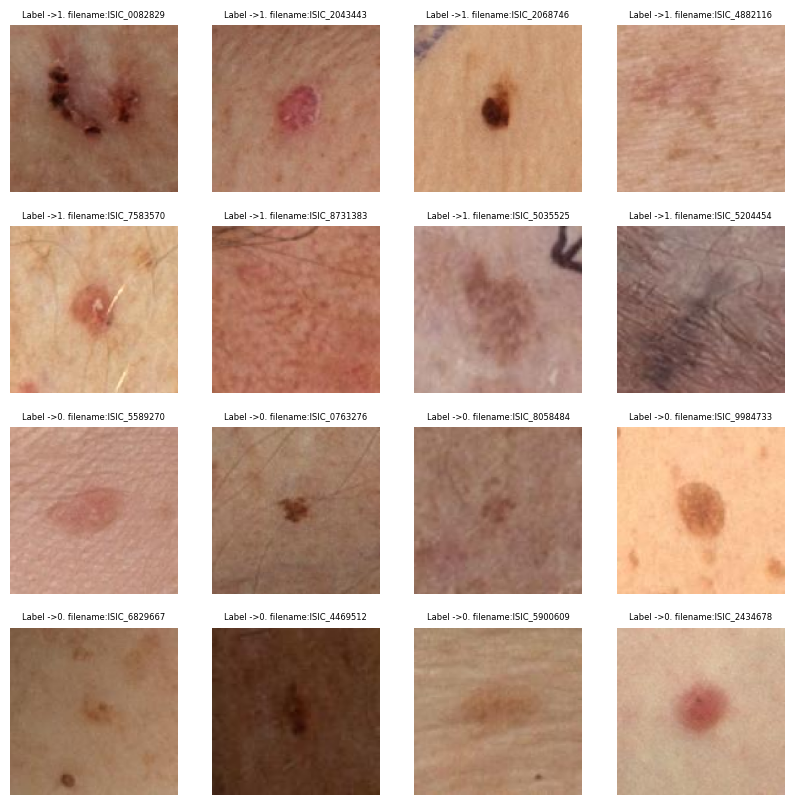

In [9]:
fig , axs = plt.subplots(nrows=4,ncols=4,figsize = (10,10))

for ax , im , target in zip(axs.flatten(),pos_img_file+neg_img_file,[1]*8+[0]*8):
    img = Image.open(f'{base_train_image_dir}/'+f'{im}.jpg')
    ax.imshow(img)
    ax.axis('off')

    ax.set_title(f'Label ->{target}. filename:{im}',fontsize= 6)


## Balacning the dataset ⚖️

In [10]:
images_paths = [] # list to store image_paths
images_labels = [] # list to store labels


pos_img_pahts = random.sample(list(train_csv_File.loc[train_csv_File['target'] == 1]['isic_id']),391)
neg_img_paths = random.sample(list(train_csv_File.loc[train_csv_File['target'] == 0]['isic_id']),391)


In [11]:
pol = []
negl = []
for i , k in zip(neg_img_paths,pos_img_pahts):
    pol.append(train_csv_File.loc[train_csv_File['isic_id'] == k]['target'].values[0])
    negl.append(train_csv_File.loc[train_csv_File['isic_id'] == i]['target'].values[0])


Storing them into main images and labels lists

In [12]:
images_paths = pos_img_pahts + neg_img_paths
images_labels = pol + negl

In [13]:
len(images_paths)
len(images_labels)

782

## Data Preprocessing 🗃️

In [14]:
def load_and_preprocess_image(im_path, label):
    im_path = tf.strings.join([f'{base_train_image_dir}/', im_path, '.jpg'], separator='')
    image = tf.io.read_file(im_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image, label

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((images_paths, images_labels))

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=len(images_paths), seed=42)

# Define the split ratio
validation_split = 0.2
dataset_size = len(images_paths)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

# Split the dataset into training and validation sets
train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)


In [15]:
len(train_dataset)

626

In [16]:
len(validation_dataset)

156

In [17]:
# Map the preprocessing function to both datasets
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch the datasets
batch_size = 5
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


## Building CNN Model 🧠 

In [18]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D,Flatten,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential

In [19]:
model = Sequential([
    Input(shape= (64,64,3)),
    Conv2D(32,(3,3),activation = 'relu',),
    Conv2D(64,(3,3),activation = 'relu'),
    Flatten(),
    Dense(128,activation = 'relu'),
    Dense(1,activation = 'sigmoid')
       
])
print("Done")

Done


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    29,491,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,510,849 (112.57 MB)

 Trainable params: 29,510,849 (112.57 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling the model

In [21]:
model.compile(optimizer='adam',loss= 'binary_crossentropy',metrics=['accuracy'])

## Fitting the Model

In [22]:
history = model.fit(train_dataset,
          validation_data= validation_dataset,
          epochs = 70,
          validation_steps = 10 )

Epoch 1/70
 16/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5274 - loss: 8.8625 

I0000 00:00:1722201590.097641      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722201590.116361      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5432 - loss: 2.7023 - val_accuracy: 0.4800 - val_loss: 0.6752
Epoch 2/70
 11/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6044 - loss: 0.6152

W0000 00:00:1722201593.218052      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6344 - loss: 0.6436 - val_accuracy: 0.8200 - val_loss: 0.5933
Epoch 3/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6371 - loss: 0.6493 - val_accuracy: 0.5400 - val_loss: 0.7279
Epoch 4/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6754 - loss: 0.6047 - val_accuracy: 0.6667 - val_loss: 0.7058
Epoch 5/70
 16/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7125 - loss: 0.5993

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7288 - loss: 0.5618 - val_accuracy: 0.7800 - val_loss: 0.5271
Epoch 6/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7122 - loss: 0.5546 - val_accuracy: 0.4600 - val_loss: 0.6754
Epoch 7/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5901 - loss: 0.6804 - val_accuracy: 0.8200 - val_loss: 0.5954
Epoch 8/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6165 - loss: 0.6694 - val_accuracy: 0.5000 - val_loss: 0.6888
Epoch 9/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6848 - loss: 0.5621 - val_accuracy: 0.8400 - val_loss: 0.4167
Epoch 10/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7237 - loss: 0.5671 - val_accuracy: 0.7400 - val_loss: 0.5578
Epoch 11/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6496 - loss: 0.6146 - val_accuracy: 0.6000 - val_loss: 0.6193
Epoch 12/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6214 - loss: 0.6517 - val_accuracy: 0.

## Saving the Model

In [23]:
model.save("/kaggle/working/SimpleCNN_70.h5")
print("saved")

saved


## Graph Validation

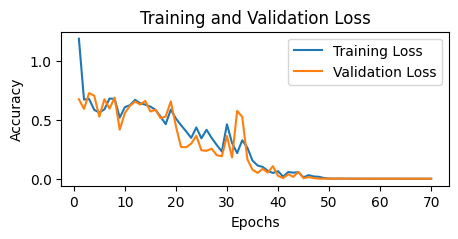

In [24]:

# Extract accuracy and validation accuracy
accuracy = history.history['loss']
val_accuracy = history.history['val_loss']

# Extract number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(5, 2))
plt.plot(epochs, accuracy, label='Training Loss')
plt.plot(epochs, val_accuracy, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


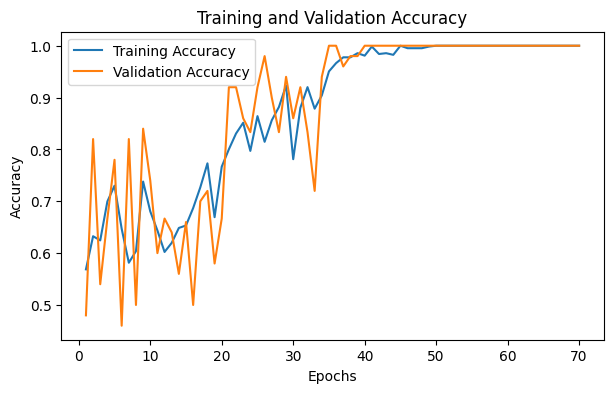

In [25]:
# Extract accuracy and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Extract number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(7, 4))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Testing on Custom Image
Just load the saved model <br>
Process the image<br>
Pass that to the model

In [26]:
from tensorflow.keras.models import load_model
# Define the function to load and preprocess the custom image
def load_and_preprocess_custom_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image

# Path to the custom image
custom_image_path = '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0051983.jpg'

# Load and preprocess the custom image
cmodel = load_model('/kaggle/working/SimpleCNN_70.h5')
custom_image = load_and_preprocess_custom_image(custom_image_path)
custom_image = tf.expand_dims(custom_image, axis=0)  # Add batch dimension

# Predict using the trained model
prediction = cmodel.predict(custom_image)

# Print the prediction
print("Prediction for the custom image:", prediction)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Prediction for the custom image: [[0.00023494]]


## Making Submission File

Reading test files form hdf5 passing them to model and getting prediction 

In [27]:
# Load the model once
cmodel = load_model('/kaggle/working/SimpleCNN_70.h5')

# Load the HDF5 file
file_path = '/kaggle/input/isic-2024-challenge/test-image.hdf5'  
image_ids = []
predictions = []
images = []

# Function to preprocess images
def preprocess_image(image):
    img_resized = cv2.resize(image, (64, 64))
    img_resized = img_resized.astype('float32') / 255.0
    return img_resized

with h5py.File(file_path, 'r') as hdf:
    # Get the number of test images
    num_test_images = len(hdf.keys())
    
    # Set batch size based on the number of test images
    if num_test_images <= 3:
        batch_size = 3
    else:
        batch_size = 150
    
    # Access each dataset and process the data
    for key in hdf.keys():
        binary_data = hdf[key][...]
        image_ids.append(key)
        
        # Convert binary data to image
        image = Image.open(io.BytesIO(binary_data))
        image = np.array(image)  # Convert PIL Image to numpy array
        preprocessed_image = preprocess_image(image)
        images.append(preprocessed_image)
        
        # If the batch size is reached, make predictions
        if len(images) == batch_size:
            images_np = np.array(images)
            batch_predictions = cmodel.predict(images_np)
            predictions.extend([f'{pred[0]:.6f}' for pred in batch_predictions])
            images = []  # Reset the list for the next batch

    # Process remaining images if any
    if images:
        images_np = np.array(images)
        batch_predictions = cmodel.predict(images_np)
        predictions.extend([f'{pred[0]:.6f}' for pred in batch_predictions])

# Print predictions
for image_id, prediction in zip(image_ids, predictions):
    print(f"Prediction for image {image_id}: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
Prediction for image ISIC_0015657: 0.880743
Prediction for image ISIC_0015729: 0.000002
Prediction for image ISIC_0015740: 0.000000


In [28]:
submission_data = pd.DataFrame({'isic_id':image_ids,'target':predictions})
submission_data

,isic_id,target
0,ISIC_0015657,0.880743
1,ISIC_0015729,0.000002
2,ISIC_0015740,0.000000


In [29]:
submission_data.to_csv("/kaggle/working/submission.csv",index=False)
print('Saved')

Saved


## End